O3 농도 예측 모델의 학습 및 모델 예측 테스트 코드

VER: 
    
    v2.2

SETUP:

    In[NOx, SOX, VOC, NH3, PM2.5]
    Out[pred. O3]

STRUCTURE:

    Conditional U-Net
    (Boundary Condition BC=1)

    model = build_model(
        ..., 
        emb_dims=[64],
        ...,
        hidden_size=[64, 96],
        ...,
        in_filters=10,
        ...
    )

PARAMETER:

    EPOCH = 500
    test_split = 0.5

In [1]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf

from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-02-27 11:32:52.242354: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 11:32:52.274130: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 11:32:52.274159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 11:32:52.274181: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 11:32:52.280531: I tensorflow/core/platform/cpu_feature_g

# Training

In [2]:
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2013.csv')
dataset_2013['Boundary'] = 1.0

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]
# -------------
label_path_2013 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013'

label_path = []
for i in range(1, 120): 
    label_path.append(os.path.join(label_path_2013, '1.00', f'ACONC.{i}'))

label_data = []
for path in label_path:
    with nc.Dataset(path) as f:
        label_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
label_data = np.array(label_data).reshape(len(label_data), 82, 67, 1)

In [3]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model'  # 모델 저장 경로

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.5  # 테스트 데이터 비율 (50%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, label_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=10,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanAbsoluteError(),
    )
    
# define callback
def scheduler(epoch, lr):
    if epoch <= 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-{epoch:02d}-{val_loss:.4f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-02-27 11:32:54.981055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22069 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-02-27 11:32:54.982606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22071 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-02-27 11:32:54.984063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22071 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-02-27 11:32:54.985579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22002 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-02-27 11:33:22.422124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 11:33:22.438612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 11:33:22.483050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 11:33:22.519162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-27 11:33:25.446560: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f10d990d670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-27 11:33:25.446591: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-27 11:33:25.446597: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-27 11:33:25.44660

2/2 [==============================] - ETA: 0s - loss: 0.1969 INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-01-0.0490/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-01-0.0490/assets


2/2 [==============================] - 48s 14s/step - loss: 0.1969 - val_loss: 0.0490 - lr: 0.0010
Epoch 2/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1122INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-02-0.0424/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-02-0.0424/assets


2/2 [==============================] - 9s 9s/step - loss: 0.1015 - val_loss: 0.0424 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - ETA: 0s - loss: 0.0674INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-03-0.0334/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-03-0.0334/assets


2/2 [==============================] - 9s 9s/step - loss: 0.0674 - val_loss: 0.0334 - lr: 0.0010
Epoch 4/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0540INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-04-0.0269/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-04-0.0269/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0485 - val_loss: 0.0269 - lr: 0.0010
Epoch 5/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0390INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-05-0.0231/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-05-0.0231/assets


2/2 [==============================] - 9s 9s/step - loss: 0.0361 - val_loss: 0.0231 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - ETA: 0s - loss: 0.0283INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-06-0.0228/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-06-0.0228/assets


2/2 [==============================] - 10s 9s/step - loss: 0.0283 - val_loss: 0.0228 - lr: 0.0010
Epoch 7/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0230INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-07-0.0228/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-07-0.0228/assets


2/2 [==============================] - 10s 9s/step - loss: 0.0214 - val_loss: 0.0228 - lr: 0.0010
Epoch 8/500
2/2 [==============================] - 0s 359ms/step - loss: 0.0174 - val_loss: 0.0271 - lr: 0.0010
Epoch 9/500
2/2 [==============================] - 0s 365ms/step - loss: 0.0145 - val_loss: 0.0282 - lr: 0.0010
Epoch 10/500
2/2 [==============================] - 0s 378ms/step - loss: 0.0139 - val_loss: 0.0288 - lr: 0.0010
Epoch 11/500
2/2 [==============================] - 0s 320ms/step - loss: 0.0120 - val_loss: 0.0302 - lr: 0.0010
Epoch 12/500
2/2 [==============================] - 0s 312ms/step - loss: 0.0103 - val_loss: 0.0325 - lr: 0.0010
Epoch 13/500
2/2 [==============================] - 0s 362ms/step - loss: 0.0104 - val_loss: 0.0305 - lr: 0.0010
Epoch 14/500
2/2 [==============================] - 0s 407ms/step - loss: 0.0102 - val_loss: 0.0310 - lr: 0.0010
Epoch 15/500
2/2 [==============================] - 0s 336ms/step - loss: 0.0100 - val_loss: 0.0328 - lr: 0.0010


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-61-0.0224/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0046 - val_loss: 0.0224 - lr: 0.0010
Epoch 62/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0044INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-62-0.0216/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-62-0.0216/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0054 - val_loss: 0.0216 - lr: 0.0010
Epoch 63/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0043INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-63-0.0214/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-63-0.0214/assets


2/2 [==============================] - 10s 9s/step - loss: 0.0050 - val_loss: 0.0214 - lr: 0.0010
Epoch 64/500
2/2 [==============================] - ETA: 0s - loss: 0.0057INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-64-0.0200/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-64-0.0200/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0057 - val_loss: 0.0200 - lr: 0.0010
Epoch 65/500
2/2 [==============================] - 0s 397ms/step - loss: 0.0039 - val_loss: 0.0204 - lr: 0.0010
Epoch 66/500
2/2 [==============================] - ETA: 0s - loss: 0.0055INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-66-0.0191/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-66-0.0191/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0055 - val_loss: 0.0191 - lr: 0.0010
Epoch 67/500
2/2 [==============================] - ETA: 0s - loss: 0.0052INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-67-0.0177/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-67-0.0177/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0052 - val_loss: 0.0177 - lr: 0.0010
Epoch 68/500
2/2 [==============================] - 0s 372ms/step - loss: 0.0055 - val_loss: 0.0182 - lr: 0.0010
Epoch 69/500
2/2 [==============================] - ETA: 0s - loss: 0.0063INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-69-0.0174/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-69-0.0174/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0063 - val_loss: 0.0174 - lr: 0.0010
Epoch 70/500
2/2 [==============================] - ETA: 0s - loss: 0.0038INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-70-0.0174/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-70-0.0174/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0038 - val_loss: 0.0174 - lr: 0.0010
Epoch 71/500
2/2 [==============================] - ETA: 0s - loss: 0.0045INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-71-0.0170/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-71-0.0170/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0045 - val_loss: 0.0170 - lr: 0.0010
Epoch 72/500
2/2 [==============================] - ETA: 0s - loss: 0.0044INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-72-0.0153/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-72-0.0153/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0044 - val_loss: 0.0153 - lr: 0.0010
Epoch 73/500
2/2 [==============================] - ETA: 0s - loss: 0.0045INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-73-0.0147/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-73-0.0147/assets


2/2 [==============================] - 8s 8s/step - loss: 0.0045 - val_loss: 0.0147 - lr: 0.0010
Epoch 74/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0034INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-74-0.0144/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-74-0.0144/assets


2/2 [==============================] - 11s 11s/step - loss: 0.0051 - val_loss: 0.0144 - lr: 0.0010
Epoch 75/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0039INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-75-0.0136/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-75-0.0136/assets


2/2 [==============================] - 8s 8s/step - loss: 0.0046 - val_loss: 0.0136 - lr: 0.0010
Epoch 76/500
2/2 [==============================] - 0s 340ms/step - loss: 0.0036 - val_loss: 0.0137 - lr: 0.0010
Epoch 77/500
2/2 [==============================] - ETA: 0s - loss: 0.0042INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-77-0.0125/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-77-0.0125/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0042 - val_loss: 0.0125 - lr: 0.0010
Epoch 78/500
2/2 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-78-0.0118/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-78-0.0118/assets


2/2 [==============================] - 11s 11s/step - loss: 0.0036 - val_loss: 0.0118 - lr: 0.0010
Epoch 79/500
2/2 [==============================] - 0s 357ms/step - loss: 0.0038 - val_loss: 0.0120 - lr: 0.0010
Epoch 80/500
2/2 [==============================] - ETA: 0s - loss: 0.0054INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-80-0.0114/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-80-0.0114/assets


2/2 [==============================] - 9s 9s/step - loss: 0.0054 - val_loss: 0.0114 - lr: 0.0010
Epoch 81/500
2/2 [==============================] - 0s 412ms/step - loss: 0.0045 - val_loss: 0.0117 - lr: 0.0010
Epoch 82/500
2/2 [==============================] - 0s 371ms/step - loss: 0.0044 - val_loss: 0.0115 - lr: 0.0010
Epoch 83/500
2/2 [==============================] - ETA: 0s - loss: 0.0047INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-83-0.0101/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-83-0.0101/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0047 - val_loss: 0.0101 - lr: 0.0010
Epoch 84/500
2/2 [==============================] - ETA: 0s - loss: 0.0046INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-84-0.0096/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-84-0.0096/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0046 - val_loss: 0.0096 - lr: 0.0010
Epoch 85/500
2/2 [==============================] - 0s 391ms/step - loss: 0.0046 - val_loss: 0.0103 - lr: 0.0010
Epoch 86/500
2/2 [==============================] - 0s 322ms/step - loss: 0.0041 - val_loss: 0.0097 - lr: 0.0010
Epoch 87/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0034INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-87-0.0085/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-87-0.0085/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0033 - val_loss: 0.0085 - lr: 0.0010
Epoch 88/500
2/2 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-88-0.0082/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-88-0.0082/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0036 - val_loss: 0.0082 - lr: 0.0010
Epoch 89/500
2/2 [==============================] - 0s 443ms/step - loss: 0.0043 - val_loss: 0.0084 - lr: 0.0010
Epoch 90/500
2/2 [==============================] - ETA: 0s - loss: 0.0039INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-90-0.0081/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-90-0.0081/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0039 - val_loss: 0.0081 - lr: 0.0010
Epoch 91/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0032INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-91-0.0077/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-91-0.0077/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0037 - val_loss: 0.0077 - lr: 0.0010
Epoch 92/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0051INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-92-0.0070/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-92-0.0070/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0050 - val_loss: 0.0070 - lr: 0.0010
Epoch 93/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0042INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-93-0.0065/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-93-0.0065/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0045 - val_loss: 0.0065 - lr: 0.0010
Epoch 94/500
2/2 [==============================] - 0s 343ms/step - loss: 0.0033 - val_loss: 0.0067 - lr: 0.0010
Epoch 95/500
2/2 [==============================] - 0s 365ms/step - loss: 0.0031 - val_loss: 0.0069 - lr: 0.0010
Epoch 96/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0026INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-96-0.0060/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-96-0.0060/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0034 - val_loss: 0.0060 - lr: 0.0010
Epoch 97/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0030INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-97-0.0058/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-97-0.0058/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0033 - val_loss: 0.0058 - lr: 0.0010
Epoch 98/500
2/2 [==============================] - 0s 331ms/step - loss: 0.0045 - val_loss: 0.0058 - lr: 0.0010
Epoch 99/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0025INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-99-0.0056/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-99-0.0056/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0034 - val_loss: 0.0056 - lr: 0.0010
Epoch 100/500
2/2 [==============================] - ETA: 0s - loss: 0.0032INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-100-0.0055/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-100-0.0055/assets


2/2 [==============================] - 9s 9s/step - loss: 0.0032 - val_loss: 0.0055 - lr: 0.0010
Epoch 101/500
2/2 [==============================] - 0s 363ms/step - loss: 0.0031 - val_loss: 0.0056 - lr: 0.0010
Epoch 102/500
2/2 [==============================] - 0s 367ms/step - loss: 0.0045 - val_loss: 0.0056 - lr: 0.0010
Epoch 103/500
2/2 [==============================] - ETA: 0s - loss: 0.0045INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-103-0.0041/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-103-0.0041/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0045 - val_loss: 0.0041 - lr: 0.0010
Epoch 104/500
2/2 [==============================] - 0s 338ms/step - loss: 0.0043 - val_loss: 0.0046 - lr: 0.0010
Epoch 105/500
2/2 [==============================] - 0s 380ms/step - loss: 0.0038 - val_loss: 0.0049 - lr: 0.0010
Epoch 106/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0029INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-106-0.0038/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-106-0.0038/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0031 - val_loss: 0.0038 - lr: 0.0010
Epoch 107/500
2/2 [==============================] - 0s 376ms/step - loss: 0.0037 - val_loss: 0.0039 - lr: 0.0010
Epoch 108/500
2/2 [==============================] - 0s 340ms/step - loss: 0.0030 - val_loss: 0.0043 - lr: 0.0010
Epoch 109/500
2/2 [==============================] - 0s 347ms/step - loss: 0.0046 - val_loss: 0.0046 - lr: 0.0010
Epoch 110/500
2/2 [==============================] - ETA: 0s - loss: 0.0040INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-110-0.0033/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-110-0.0033/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0040 - val_loss: 0.0033 - lr: 0.0010
Epoch 111/500
2/2 [==============================] - 0s 376ms/step - loss: 0.0034 - val_loss: 0.0039 - lr: 0.0010
Epoch 112/500
2/2 [==============================] - 0s 364ms/step - loss: 0.0035 - val_loss: 0.0040 - lr: 0.0010
Epoch 113/500
2/2 [==============================] - 0s 313ms/step - loss: 0.0030 - val_loss: 0.0035 - lr: 0.0010
Epoch 114/500
2/2 [==============================] - 0s 395ms/step - loss: 0.0033 - val_loss: 0.0035 - lr: 0.0010
Epoch 115/500
2/2 [==============================] - 0s 402ms/step - loss: 0.0040 - val_loss: 0.0037 - lr: 0.0010
Epoch 116/500
2/2 [==============================] - 0s 369ms/step - loss: 0.0031 - val_loss: 0.0036 - lr: 0.0010
Epoch 117/500
2/2 [==============================] - 0s 411ms/step - loss: 0.0045 - val_loss: 0.0043 - lr: 0.0010
Epoch 118/500
2/2 [==============================] - 0s 347ms/step - loss: 0.0041 - val_loss: 0.0039 - 

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-121-0.0030/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0042 - val_loss: 0.0030 - lr: 0.0010
Epoch 122/500
2/2 [==============================] - 0s 385ms/step - loss: 0.0039 - val_loss: 0.0047 - lr: 0.0010
Epoch 123/500
2/2 [==============================] - 0s 386ms/step - loss: 0.0037 - val_loss: 0.0047 - lr: 0.0010
Epoch 124/500
2/2 [==============================] - 0s 372ms/step - loss: 0.0027 - val_loss: 0.0032 - lr: 0.0010
Epoch 125/500
2/2 [==============================] - 0s 341ms/step - loss: 0.0048 - val_loss: 0.0044 - lr: 0.0010
Epoch 126/500
2/2 [==============================] - 0s 327ms/step - loss: 0.0034 - val_loss: 0.0038 - lr: 0.0010
Epoch 127/500
2/2 [==============================] - 0s 395ms/step - loss: 0.0041 - val_loss: 0.0041 - lr: 0.0010
Epoch 128/500
2/2 [==============================] - 0s 372ms/step - loss: 0.0033 - val_loss: 0.0047 - lr: 0.0010
Epoch 129/500
2/2 [==============================] - 0s 335ms/step - loss: 0.0034 - val_loss: 0.0033 - 

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-330-0.0029/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0025 - val_loss: 0.0029 - lr: 0.0010
Epoch 331/500
2/2 [==============================] - ETA: 0s - loss: 0.0022INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-331-0.0021/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-331-0.0021/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0022 - val_loss: 0.0021 - lr: 0.0010
Epoch 332/500
2/2 [==============================] - 0s 359ms/step - loss: 0.0016 - val_loss: 0.0030 - lr: 0.0010
Epoch 333/500
2/2 [==============================] - 0s 398ms/step - loss: 0.0014 - val_loss: 0.0032 - lr: 0.0010
Epoch 334/500
2/2 [==============================] - 0s 394ms/step - loss: 0.0020 - val_loss: 0.0034 - lr: 0.0010
Epoch 335/500
2/2 [==============================] - 0s 398ms/step - loss: 0.0017 - val_loss: 0.0034 - lr: 0.0010
Epoch 336/500
2/2 [==============================] - 0s 370ms/step - loss: 0.0015 - val_loss: 0.0024 - lr: 0.0010
Epoch 337/500
2/2 [==============================] - 0s 336ms/step - loss: 0.0017 - val_loss: 0.0027 - lr: 0.0010
Epoch 338/500
2/2 [==============================] - 0s 442ms/step - loss: 0.0018 - val_loss: 0.0029 - lr: 0.0010
Epoch 339/500
2/2 [==============================] - 0s 348ms/step - loss: 0.0015 - val_loss: 0.0038 - 

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-386-0.0019/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0015 - val_loss: 0.0019 - lr: 0.0010
Epoch 387/500
2/2 [==============================] - ETA: 0s - loss: 0.0013INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-387-0.0018/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-387-0.0018/assets


2/2 [==============================] - 9s 9s/step - loss: 0.0013 - val_loss: 0.0018 - lr: 0.0010
Epoch 388/500
2/2 [==============================] - 0s 405ms/step - loss: 0.0015 - val_loss: 0.0021 - lr: 0.0010
Epoch 389/500
2/2 [==============================] - 0s 336ms/step - loss: 0.0013 - val_loss: 0.0021 - lr: 0.0010
Epoch 390/500
2/2 [==============================] - 0s 346ms/step - loss: 0.0013 - val_loss: 0.0019 - lr: 0.0010
Epoch 391/500
2/2 [==============================] - 0s 368ms/step - loss: 0.0014 - val_loss: 0.0019 - lr: 0.0010
Epoch 392/500
2/2 [==============================] - 2s 2s/step - loss: 0.0012 - val_loss: 0.0018 - lr: 0.0010
Epoch 393/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0011INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-393-0.0015/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-393-0.0015/assets


2/2 [==============================] - 9s 9s/step - loss: 0.0012 - val_loss: 0.0015 - lr: 0.0010
Epoch 394/500
2/2 [==============================] - 0s 375ms/step - loss: 0.0011 - val_loss: 0.0023 - lr: 0.0010
Epoch 395/500
2/2 [==============================] - 0s 373ms/step - loss: 0.0012 - val_loss: 0.0020 - lr: 0.0010
Epoch 396/500
2/2 [==============================] - 0s 344ms/step - loss: 0.0012 - val_loss: 0.0019 - lr: 0.0010
Epoch 397/500
2/2 [==============================] - 0s 360ms/step - loss: 8.6117e-04 - val_loss: 0.0023 - lr: 0.0010
Epoch 398/500
2/2 [==============================] - 0s 358ms/step - loss: 0.0012 - val_loss: 0.0021 - lr: 0.0010
Epoch 399/500
2/2 [==============================] - 0s 333ms/step - loss: 0.0013 - val_loss: 0.0019 - lr: 0.0010
Epoch 400/500
2/2 [==============================] - 0s 369ms/step - loss: 0.0010 - val_loss: 0.0021 - lr: 0.0010
Epoch 401/500
2/2 [==============================] - 0s 371ms/step - loss: 9.9303e-04 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-454-0.0015/assets


2/2 [==============================] - 9s 8s/step - loss: 0.0013 - val_loss: 0.0015 - lr: 0.0010
Epoch 455/500
2/2 [==============================] - 0s 344ms/step - loss: 0.0013 - val_loss: 0.0020 - lr: 0.0010
Epoch 456/500
2/2 [==============================] - 0s 370ms/step - loss: 0.0012 - val_loss: 0.0016 - lr: 0.0010
Epoch 457/500
2/2 [==============================] - 0s 395ms/step - loss: 9.3717e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 458/500
2/2 [==============================] - 0s 353ms/step - loss: 0.0011 - val_loss: 0.0016 - lr: 0.0010
Epoch 459/500
2/2 [==============================] - 0s 432ms/step - loss: 0.0012 - val_loss: 0.0019 - lr: 0.0010
Epoch 460/500
2/2 [==============================] - ETA: 0s - loss: 9.4403e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-460-0.0015/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-460-0.0015/assets


2/2 [==============================] - 10s 10s/step - loss: 9.4403e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 461/500
2/2 [==============================] - 0s 371ms/step - loss: 8.6892e-04 - val_loss: 0.0020 - lr: 0.0010
Epoch 462/500
2/2 [==============================] - 0s 368ms/step - loss: 0.0011 - val_loss: 0.0018 - lr: 0.0010
Epoch 463/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0011INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-463-0.0015/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-463-0.0015/assets


2/2 [==============================] - 10s 10s/step - loss: 0.0012 - val_loss: 0.0015 - lr: 0.0010
Epoch 464/500
2/2 [==============================] - 0s 374ms/step - loss: 0.0011 - val_loss: 0.0018 - lr: 0.0010
Epoch 465/500
2/2 [==============================] - ETA: 0s - loss: 9.1363e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-465-0.0013/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-465-0.0013/assets


2/2 [==============================] - 10s 10s/step - loss: 9.1363e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 466/500
2/2 [==============================] - 0s 365ms/step - loss: 9.0523e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 467/500
2/2 [==============================] - 0s 372ms/step - loss: 0.0010 - val_loss: 0.0016 - lr: 0.0010
Epoch 468/500
2/2 [==============================] - 0s 344ms/step - loss: 0.0011 - val_loss: 0.0018 - lr: 0.0010
Epoch 469/500
2/2 [==============================] - 0s 354ms/step - loss: 0.0013 - val_loss: 0.0014 - lr: 0.0010
Epoch 470/500
2/2 [==============================] - 0s 371ms/step - loss: 9.2098e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 471/500
2/2 [==============================] - 0s 320ms/step - loss: 8.9588e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 472/500
2/2 [==============================] - 0s 371ms/step - loss: 0.0012 - val_loss: 0.0016 - lr: 0.0010
Epoch 473/500
2/2 [==============================] - 0s 366ms/step - loss: 7.9416e-04 -

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model-500-0.0013/assets


2/2 [==============================] - 8s 8s/step - loss: 0.0011 - val_loss: 0.0013 - lr: 0.0010
INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model/assets


' '

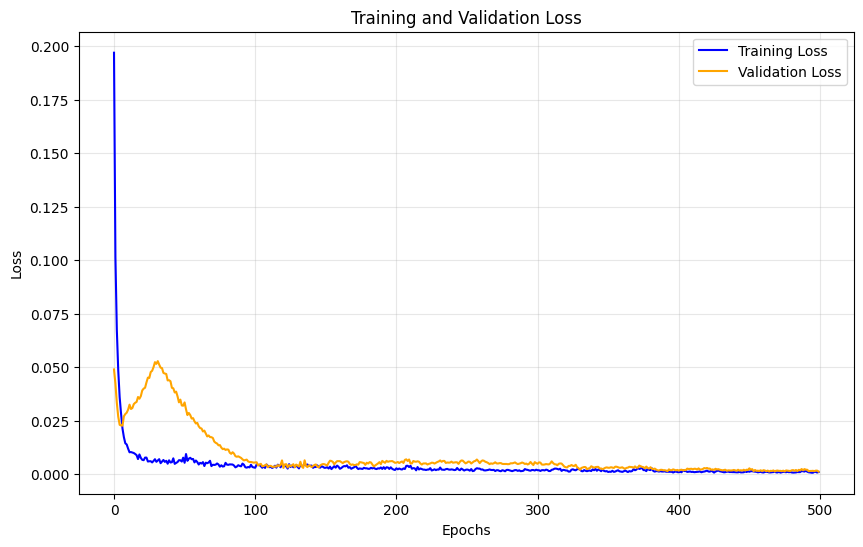

In [4]:
plot_loss(history)

# Prediction & Performance

In [5]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [6]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v2/v2.2/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2013.csv')
dataset_2013['Boundary'] = 1.0

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2013 = "/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2013, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 Nitrate
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 1s 357ms/step


In [7]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [8]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

In [9]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


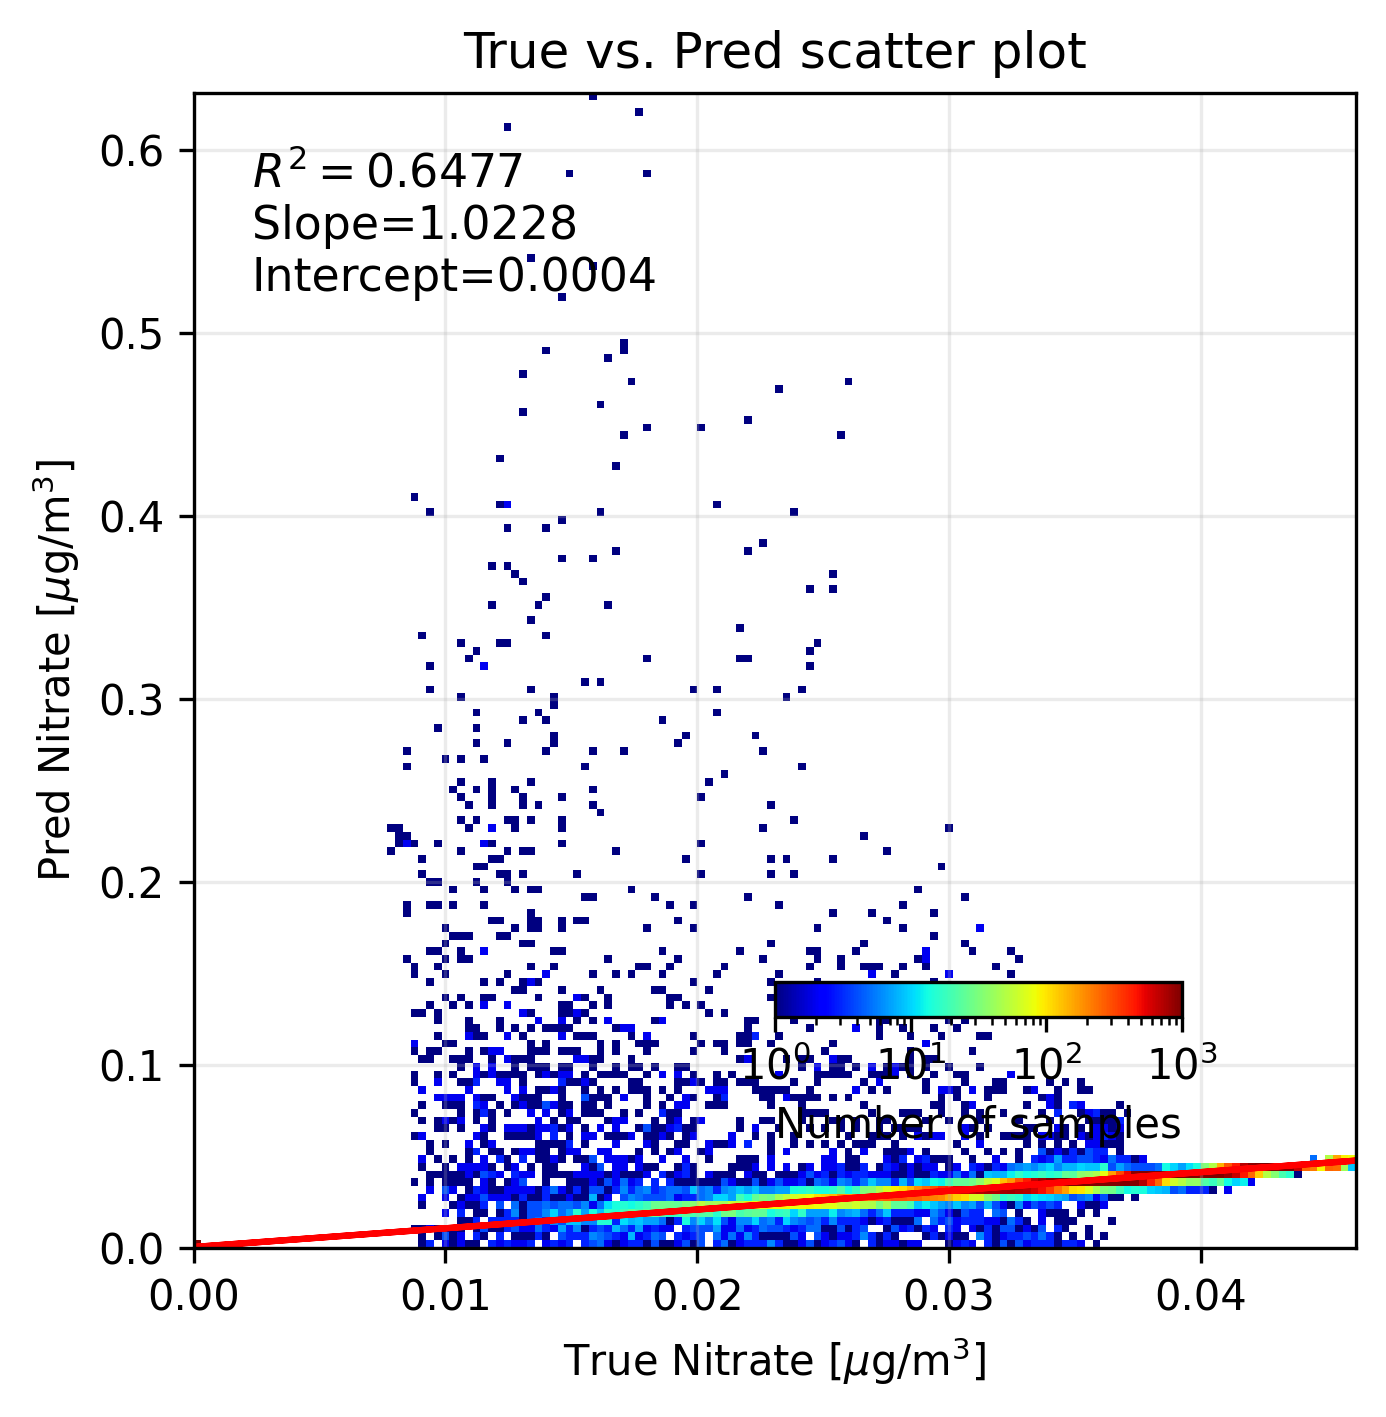

In [10]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

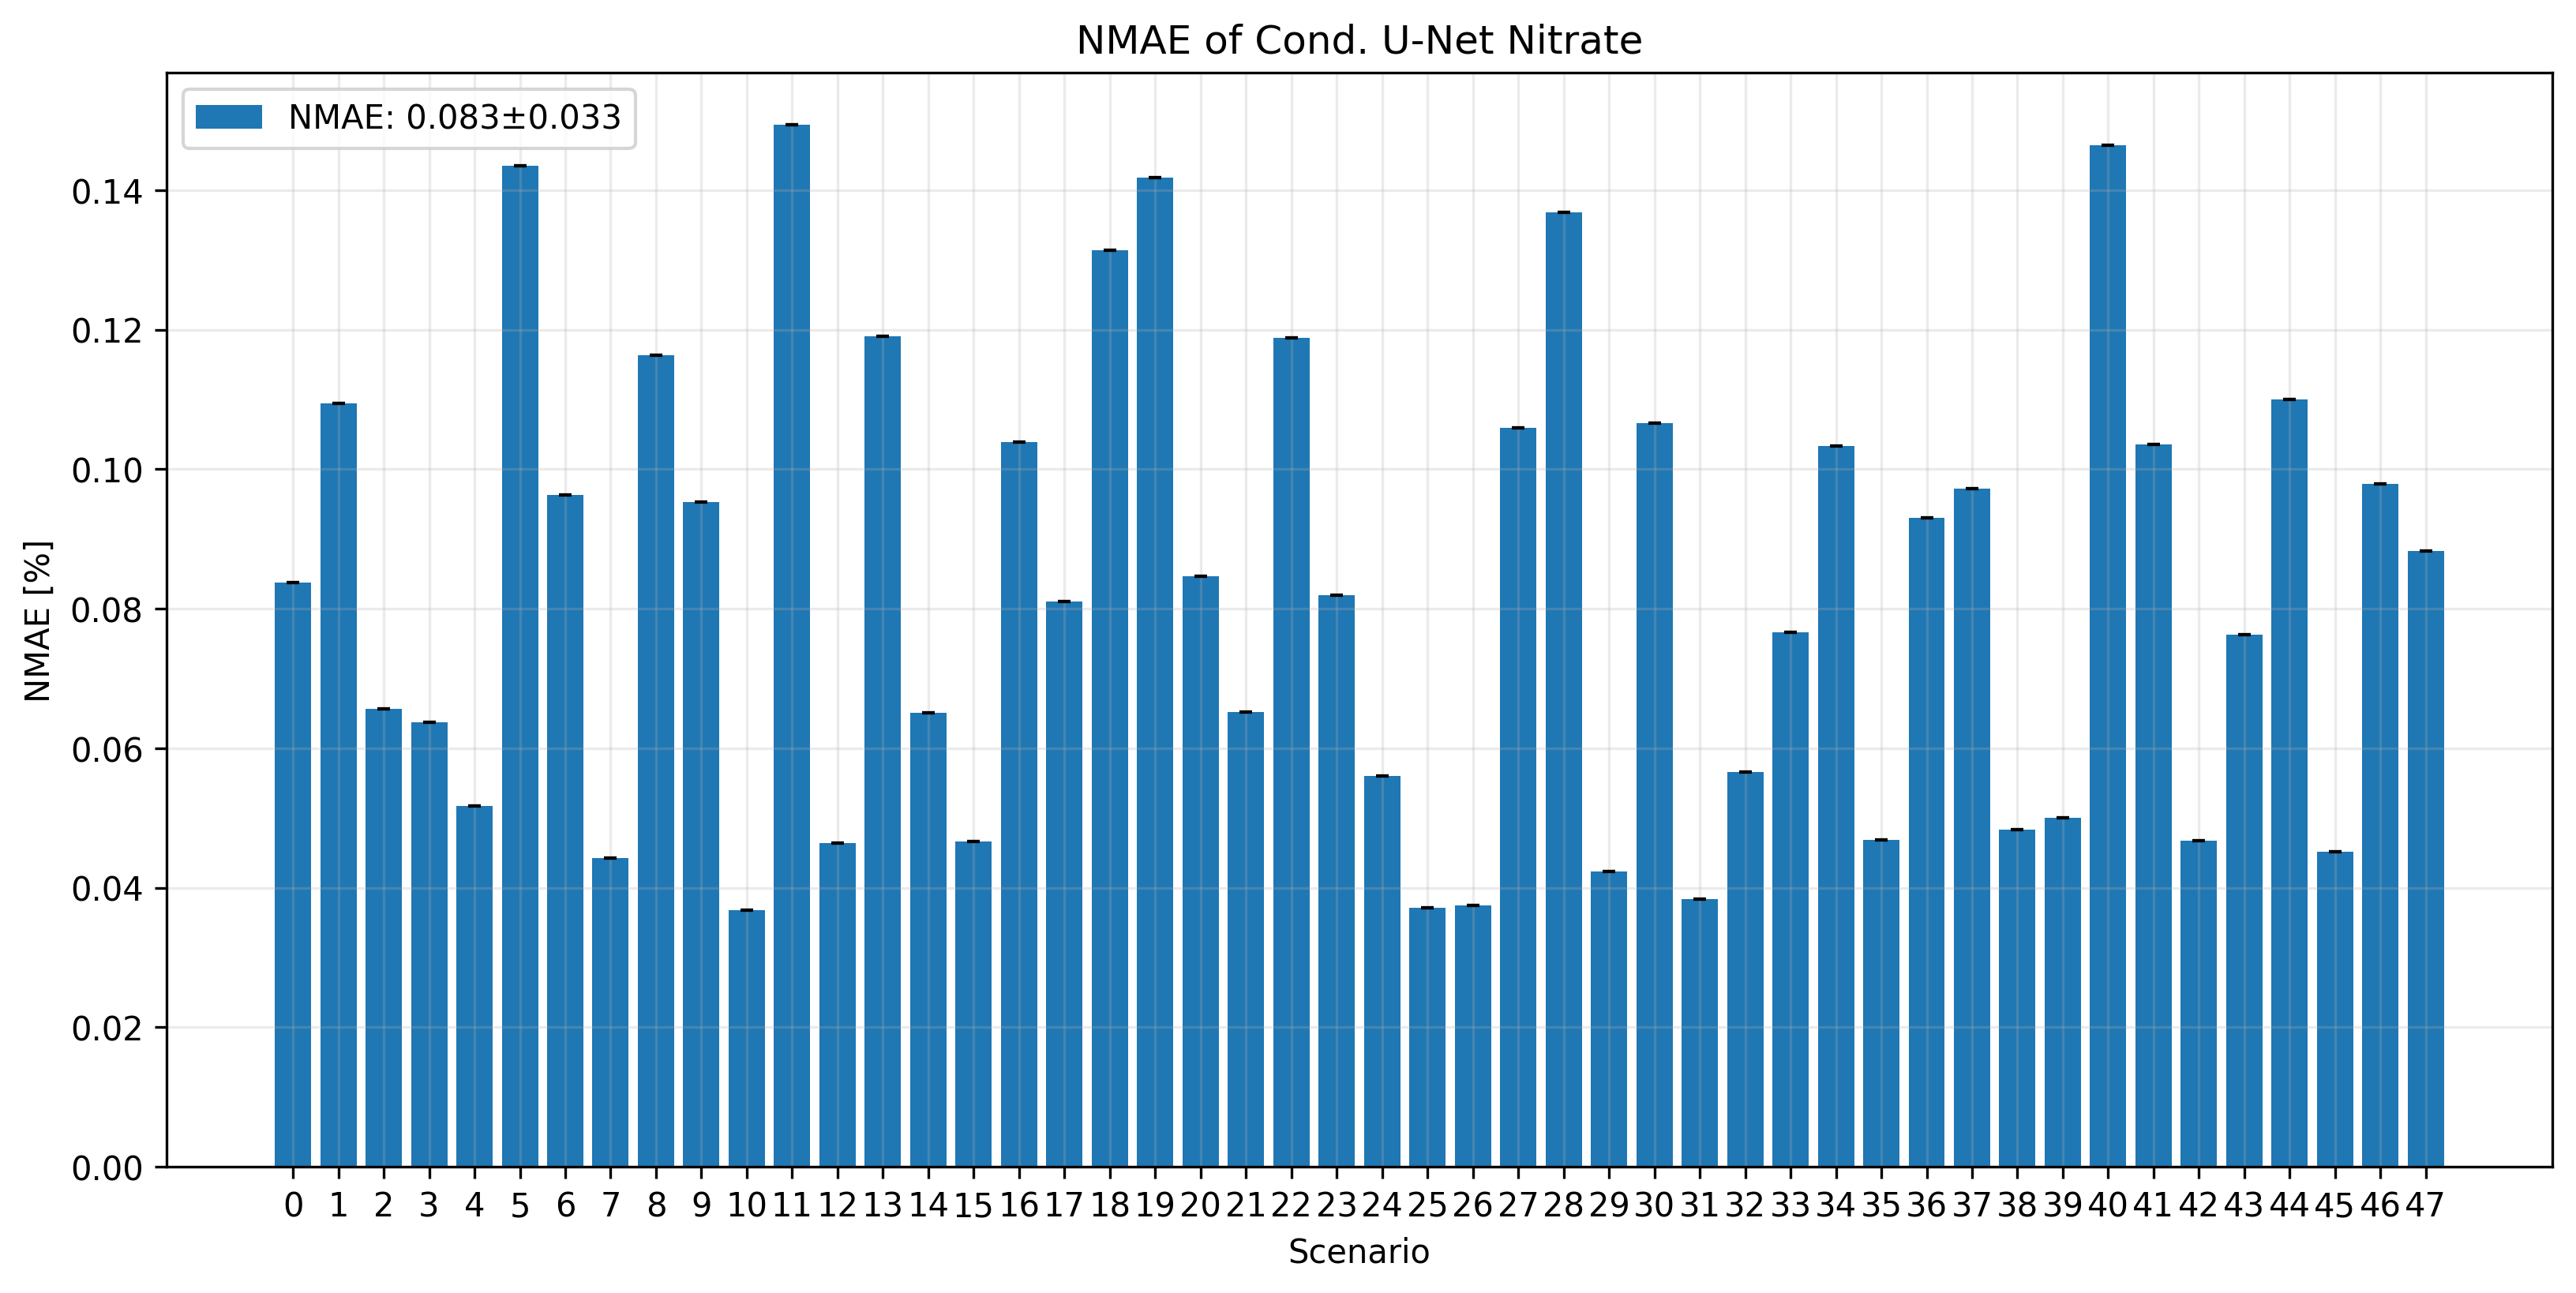

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

In [12]:
# np.set_printoptions(threshold=sys.maxsize)
# print(true_conc_map_w_lines[17])

[17]


/tmp/ipykernel_1970863/1207372777.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1970863/1207372777.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1970863/1207372777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1970863/1207372777.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1970863/1207372777.py:67: UserWarning: set_ti

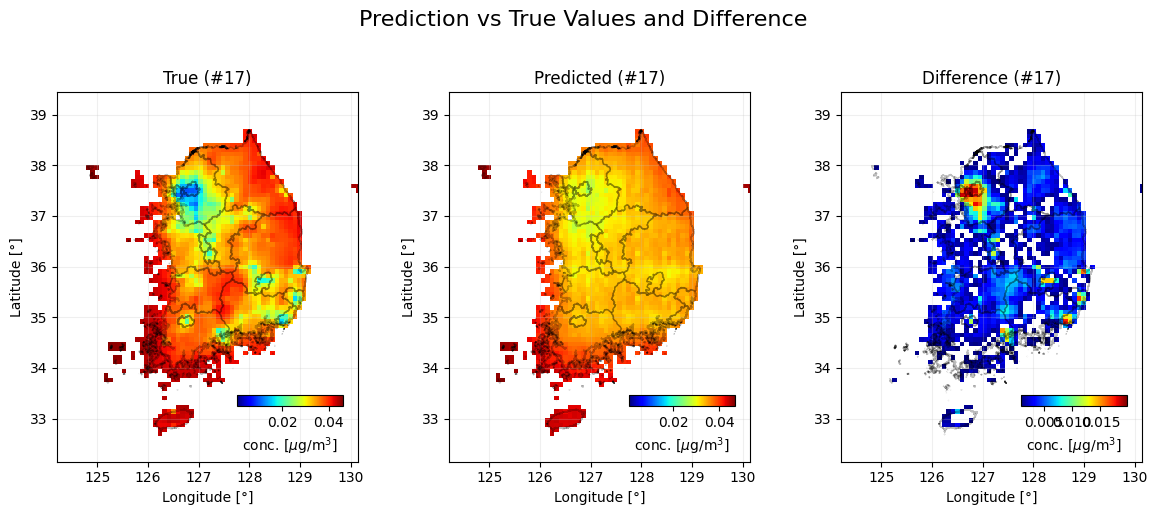

In [13]:
def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = []
        indices.append(index) 
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=17)

In [14]:
true_conc_map_w_lines_re = true_conc_map_w_lines
pred_conc_map_w_lines_re = pred_conc_map_w_lines

true_conc_map_w_lines_re = np.delete(true_conc_map_w_lines, 17, axis=0)
pred_conc_map_w_lines_re = np.delete(pred_conc_map_w_lines, 17, axis=0)

print(true_conc_map_w_lines_re.shape)
print(pred_conc_map_w_lines_re.shape)

(47, 82, 67)
(47, 82, 67)


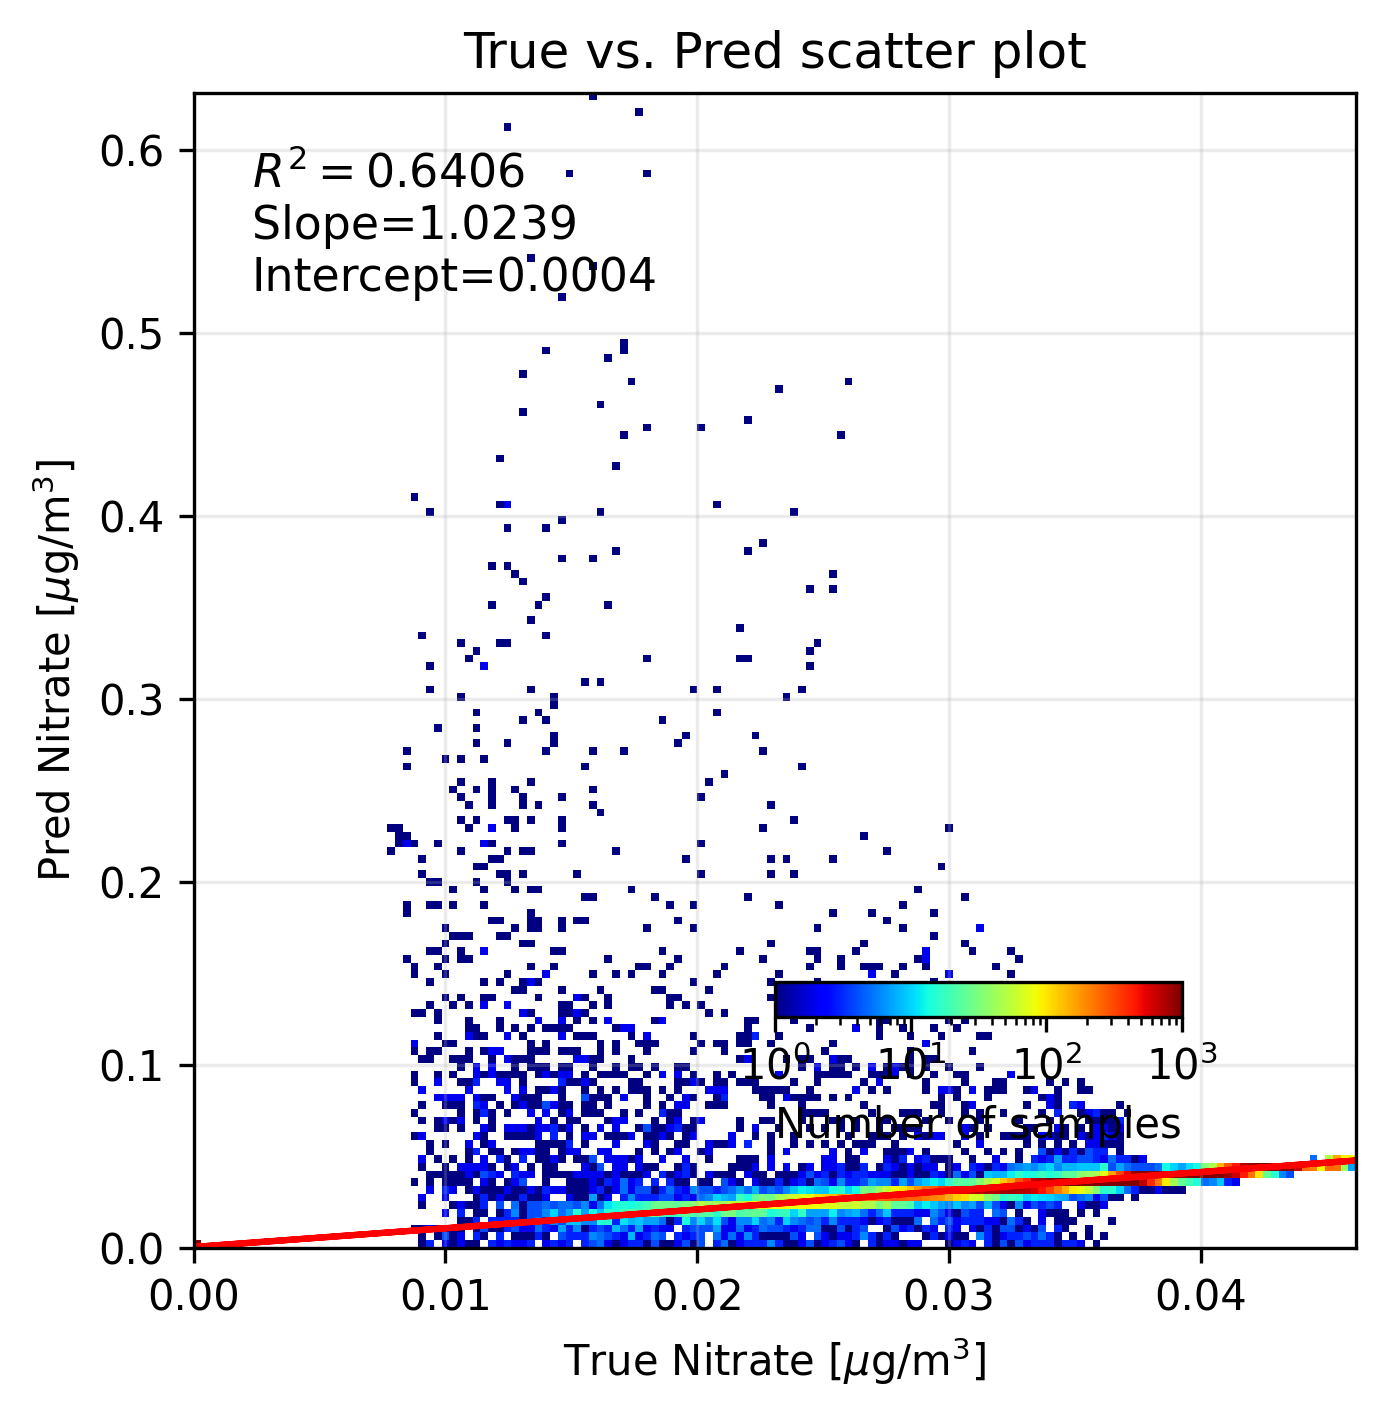

In [15]:
y_true_modi = true_conc_map_w_lines_re.reshape(-1)
y_pred_modi = pred_conc_map_w_lines_re.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

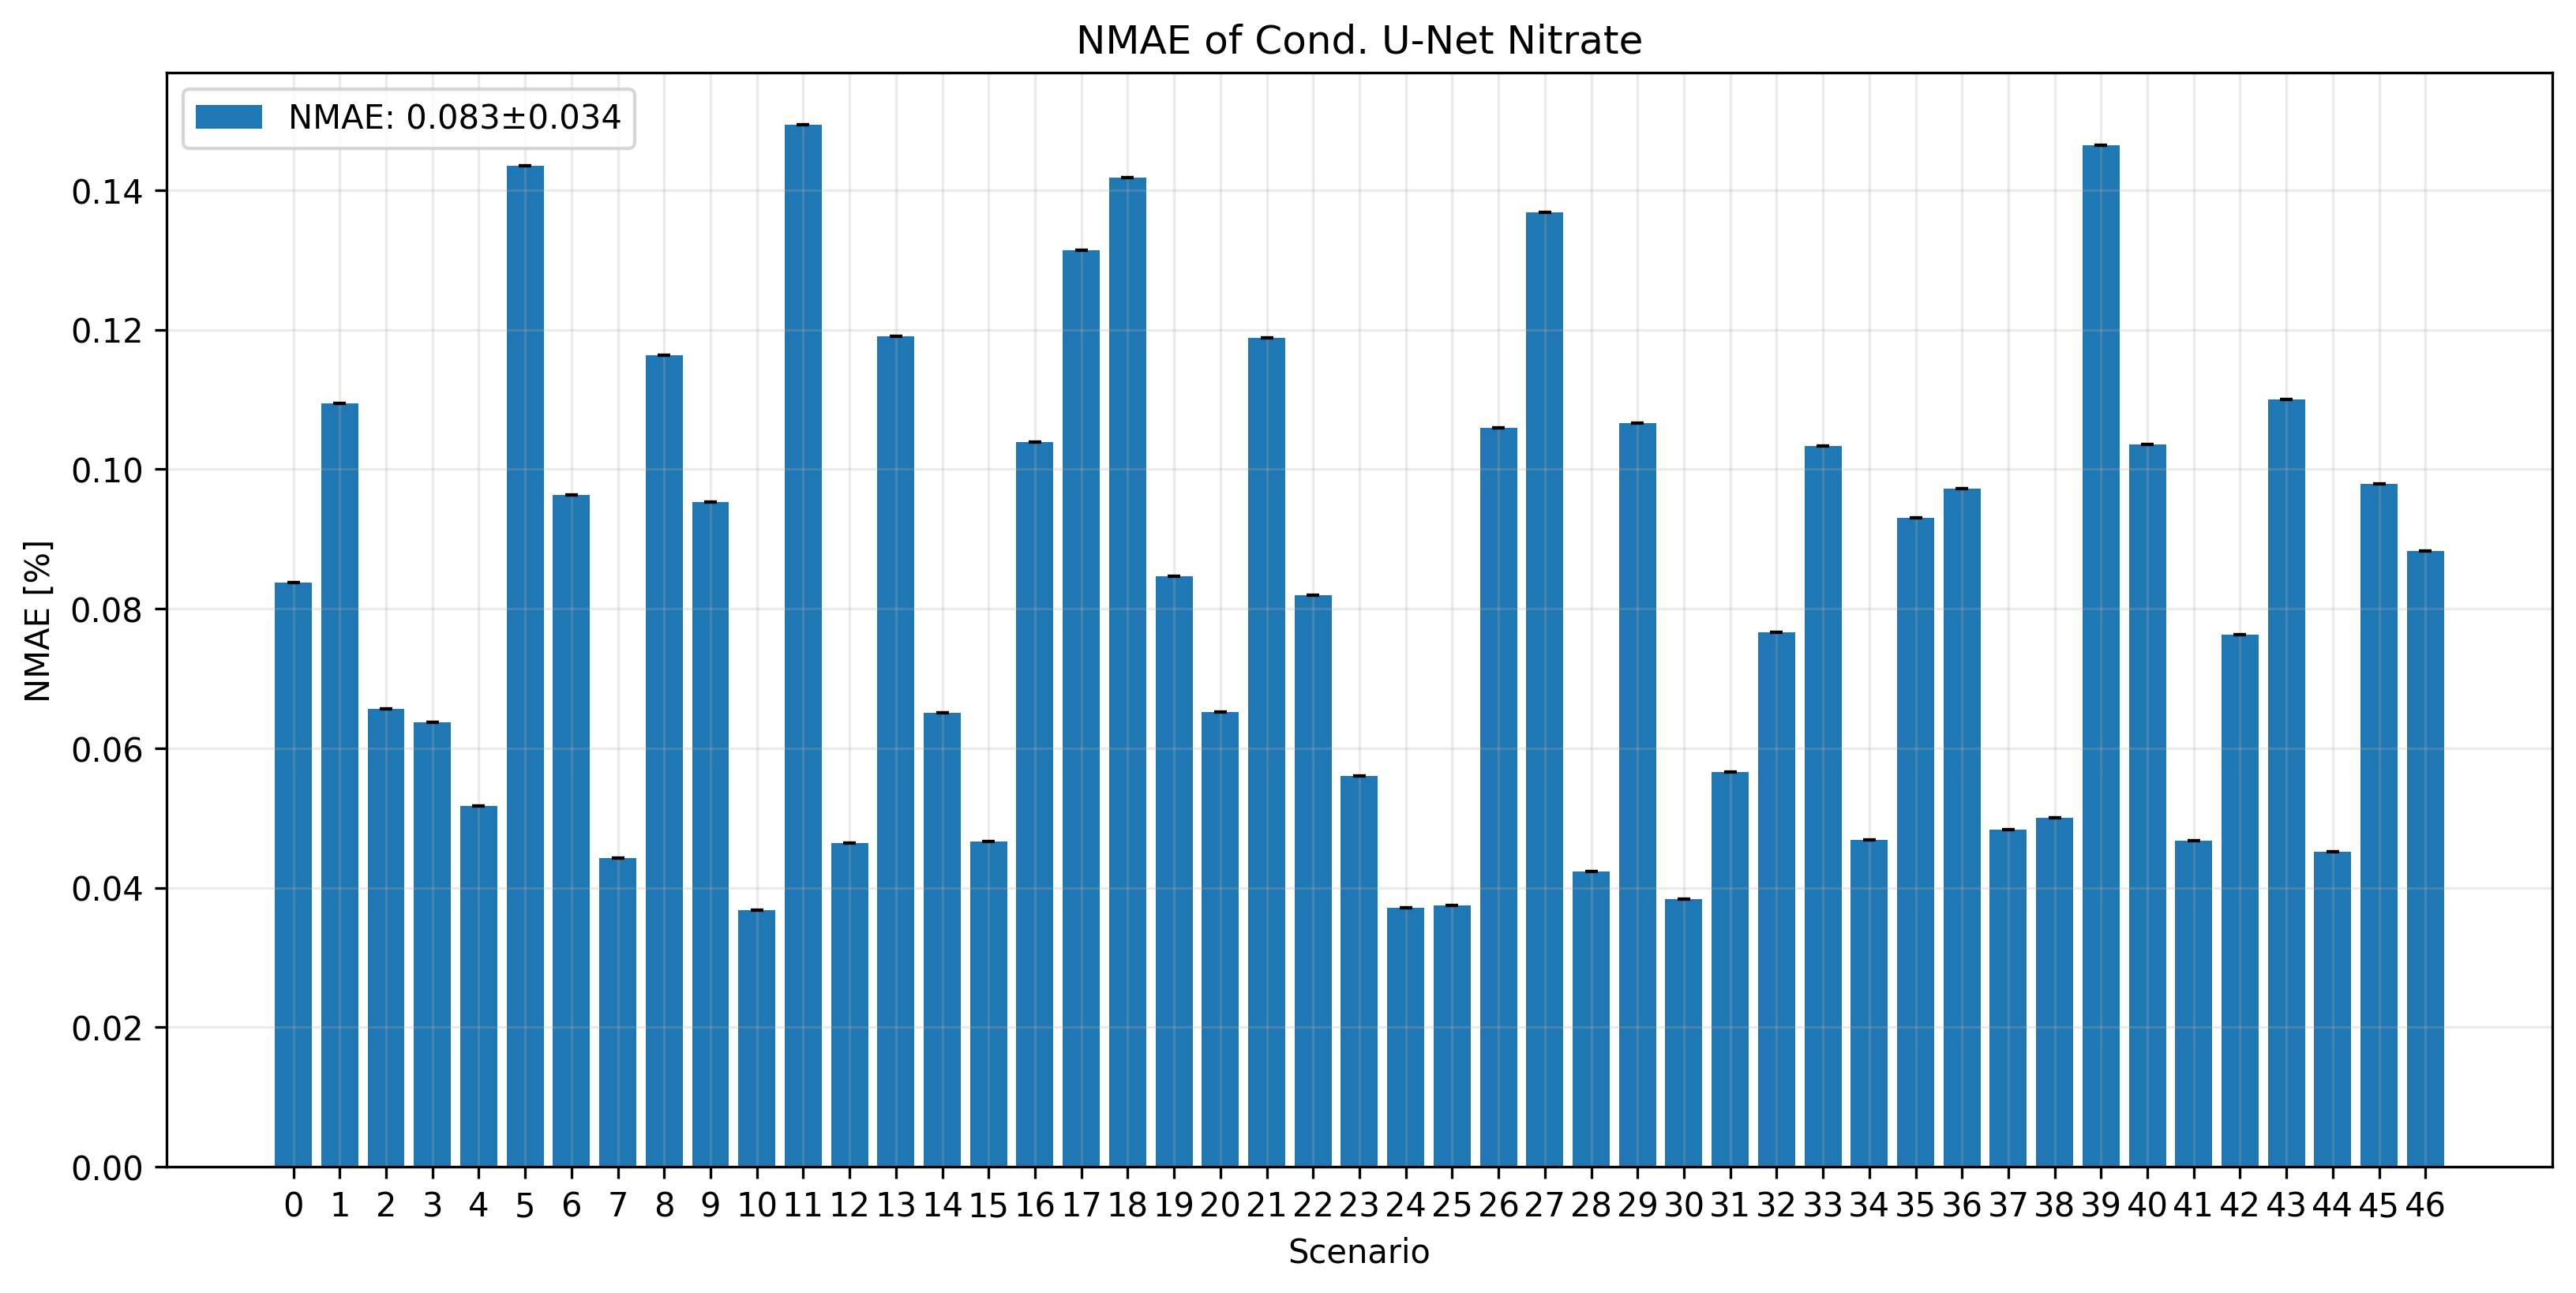

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines_re, pred_conc_map_w_lines_re)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]-1), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]-1), range(y_test.shape[0]-1))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()